In [1]:
import os
import sys
import pandas as pd
sys.path.append('..')
from unstructured.staging.base import elements_from_json
from langchain_core.documents import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer, util
import numpy as np
from src.utils.paths import get_project_path
from vector_service.vector_db import *
from chatbot_app.chatbot import *

c:\Users\SuperKROT\Desktop\Project\SciNanoAI\venv\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_uri" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\SuperKROT\Desktop\Project\SciNanoAI\venv\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
c:\Users\SuperKROT\Desktop\Project\SciNanoAI\venv\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_version" in _BaseYandexGPT has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


# UNST

In [2]:
# def load_processed_files(directory_path: str) -> list:
#     elements = []
#     for filename in os.listdir(directory_path):
#         if filename.endswith('.json'):
#             file_path = os.path.join(directory_path, filename)
#             try:
#                 elements.extend(elements_from_json(filename=file_path))
#             except IOError:
#                 print(f"Error: Could not read file {filename}.")

#     return elements

# elements = load_processed_files(os.path.join(get_project_path(), 'data', 'pars_2'))

In [3]:
# documents = []
# for element in elements:
#     metadata = element.metadata.to_dict()
#     documents.append(Document(page_content=element.text, metadata=metadata))

In [4]:
# db = FAISS.from_documents(
#     documents, 
#     HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large"))
# retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 5})

In [5]:
# db.save_local("/home/students/krotkov/SciNanoAI/db/intfloat_multilingual-e5-large_22")

In [2]:
vec = VectorDatabase(
    db_path=os.path.join(get_project_path(), "db", "intfloat_multilingual-e5-large"),
    model_name="intfloat/multilingual-e5-large"
    )

In [3]:
chatbot = ChatBot(llm_model="openai/gpt-4o-mini", data_base=vec)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


In [5]:
dd = chatbot.generate_response('Каковы механизмы, лежащие в основе дифференцировки мезенхимальных стволовых клеток (hMSCs) в нейроноподобные клетки?')
print(dd)

differentiation of hMSCs has been studied by other groups. The transdifferentiation can be induced by neuronal induc- tion medium [14-17] and/or cell contact with neurons [18]. The mechanism responsible for the transdifferentiation of mesenchymal stem cells to neurons, which are non- mesenchymal derivatives, is not well understood. [Yim E. K. F., Pang S. W., Leong K. W. Synthetic nanostructures inducing differentiation of human mesenchymal stem cells into neuronal lineage //Experimental cell research. – 2007. – Т. 313. – №. 9. – С. 1820-1829.]

type and proposed mechanisms. J Mat Sci Mater Med 2010;31:939—46. [12_4_Полина_j.biomaterials.2013.01.018.pdf]

hMSCs and to regulate the expression of nuclear lamina genes, [Максим. seong-et-al-2020-size-tunable-nanoneedle-arrays-for-influencing-stem-cell-morphology-gene-expression-and-nuclear.pdf]

4,3. How does nanotopography promote osteogenic differentiation of hASCs? [Lv L. et al. The nanoscale geometry of TiO2 nanotubes influences the ost

In [3]:
data = pd.read_csv("openai_new_save.csv")   

In [9]:
model = ["openai/gpt-4o-mini", "openai/gpt-4o-2024-11-20", "meta-llama/llama-3.1-8b-instruct", "YandexGPT4", "GigaChat-Pro"][4]

generated = data["RAG_Ответ"].replace(np.NaN, "Нет")
references = data['Правильный ответ\xa0'].replace(np.NaN, "Нет")


references = [ref.replace("\n", " ").strip() for ref in references]
generated = [pred.replace("\n", " ").strip() for pred in generated]

## Accuracy

In [18]:
from openai import OpenAI

def classify_responses(data_q, data_c, data_m):

    classifications = []

    openai_api_key = os.environ["OPENAI_API_KEY"]
    openai_api_base = os.environ["OPENAI_API_BASE"]
    

    for question, correct_answer, model_answer in zip(data_q, data_c, data_m):
        # Формируем запрос для ChatGPT
        prompt = f"Вопрос: {question}\n\n" \
                 f"Эталонный ответ: {correct_answer}\n\n" \
                 f"Ответ модели: {model_answer}\n\n" \
                 "Оцени, правильно ли ответила модель на поставленный вопрос. Оценивай не точное 100% совпадение ответа с эталонным, а скорее правильность ответа на поставленный вопрос по сравнению с эталонным (1 - правильно, 0 - неправильно)." \
                 " Ответь только цифрой."

        try:
            openai_client = OpenAI(
                base_url=openai_api_base
                )

            response = openai_client.chat.completions.create(
                model="openai/gpt-4o-2024-11-20",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.2,
                max_tokens=4096
            )
            classification = int(response.choices[0].message.content.strip())
            classifications.append(classification)

        except Exception as e:
            print(f"Ошибка: {e}")
            classifications.append(0)  # Если ошибка, считаем, что ответ неверный

    return classifications

ans = classify_responses(data["Запрос"], data["Модельный ответ"], data["openai/gpt-4-turbo"])

np.mean(ans)

0.7407407407407407

## BERTScore

In [10]:
import torch
from bert_score import BERTScorer

scorer = BERTScorer(model_type="bert-base-multilingual-cased", lang="ru")
P, R, F1 = scorer.score(generated, references)
print(torch.mean(F1))
print(f"prec:{P}, reacall: {R}, f1: {F1}", sep="\n")

tensor(0.6813)
prec:tensor([0.6579, 0.5909, 0.6734, 0.6853, 0.6687, 0.6607, 0.6626, 0.6515, 0.6632,
        0.6542, 0.6611, 0.6521, 0.6687, 0.6764, 0.6696, 0.6651, 0.6951, 0.6790,
        0.7095, 0.6831, 0.6904, 0.6667, 0.6843, 0.6983, 0.6987, 0.6702, 0.6975,
        0.6889, 0.6412, 0.6855, 0.6828, 0.6436, 0.7057, 0.6873, 0.6803, 0.6756,
        0.7001, 0.6906, 0.7066, 0.7113, 0.6787, 0.7034, 0.6528, 0.6655, 0.6902,
        0.6890, 0.6906, 0.6863, 0.6842, 0.6734, 0.6554, 0.6864, 0.6745, 0.6636,
        0.6975, 0.6628, 0.6972, 0.6944, 0.6834, 0.6890, 0.6913, 0.6786, 0.6590,
        0.6737, 0.6958, 0.6907, 0.6797, 0.6607, 0.6729, 0.6818, 0.6846, 0.7186,
        0.6949, 0.6760, 0.6898, 0.7149, 0.7180, 0.6931, 0.6798, 0.7117, 0.6863,
        0.6835, 0.6931, 0.6793, 0.6935, 0.6392, 0.7397, 0.6854, 0.6866, 0.6681,
        0.7143, 0.7366, 0.7263, 0.6955, 0.6864, 0.6949, 0.6633, 0.6755, 0.4270,
        0.6923, 0.6567, 0.6916, 0.6905, 0.6943, 0.7025, 0.6979, 0.6792, 0.6916,
        0.6907, 0.71

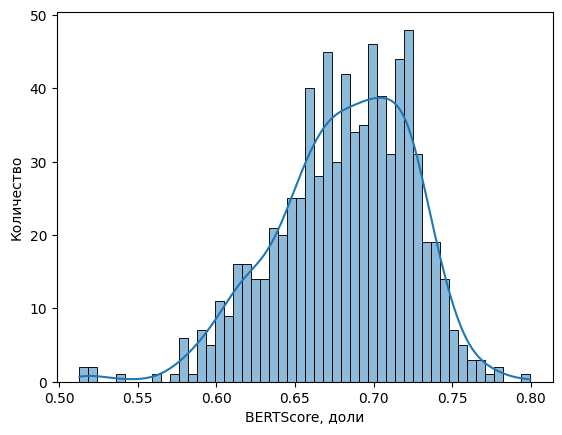

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(F1.detach().cpu().numpy(), bins=50, kde=True)
plt.xlabel('BERTScore, доли')
plt.ylabel("Количество")
plt.show()

## Cosin Sim

In [11]:
# 4. Cosine Similarity (Sentence-BERT)
model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

def calculate_cosine_similarity(references, generated):

    model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

    cosine_scores = []
    for ref, gen in zip(references, generated):
        ref_embedding = model.encode(ref, convert_to_tensor=True)
        gen_embedding = model.encode(gen, convert_to_tensor=True)
        cosine_score = util.pytorch_cos_sim(ref_embedding, gen_embedding).item()
        cosine_scores.append(cosine_score)
    return cosine_scores

cosine_scores = calculate_cosine_similarity(references, generated)
print("Cosine Similarity Scores:", np.mean(cosine_scores))


Cosine Similarity Scores: 0.7630147335841199


In [18]:
len(cosine_scores)

764

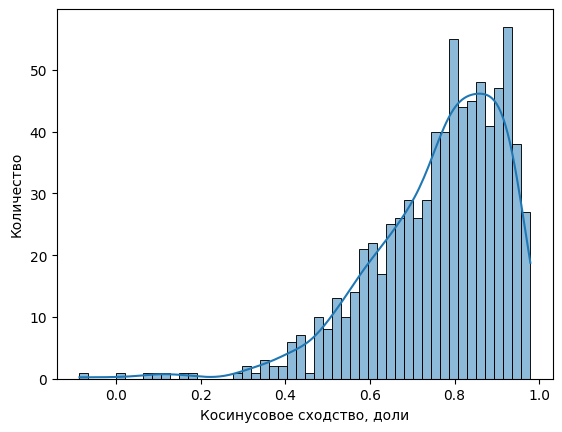

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(cosine_scores, bins=50, kde=True)
plt.xlabel('Косинусовое сходство, доли')
plt.ylabel("Количество")
plt.show()